In [1]:
!pip install scanpy

     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 80 kB 4.2 MB/s 
     |████████████████████████████████| 127 kB 27.0 MB/s 
     |████████████████████████████████| 1.1 MB 25.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=d7ef9aa23e7658bf08c632a50cf709ab31ebd5023c7c9469b1a33d6b7adf409c
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=2b8fdfb671acdf5bb94a3f6a46c60098e6259432375c14fcba8a31bff3f25915
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=aaf9f7591a1fc649110be69eb9e0d7ced8a894ccdad6d91c7942158ad76c706f
  Stored in directory: /root/.cache/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install leidenalg

     |████████████████████████████████| 1.4 MB 4.7 MB/s 
     |████████████████████████████████| 3.2 MB 43.5 MB/s 


In [4]:
%pip install episcanpy

     |████████████████████████████████| 106 kB 4.8 MB/s 
     |████████████████████████████████| 185 kB 43.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.1 MB 36.7 MB/s 
     |████████████████████████████████| 9.9 MB 26.6 MB/s 
  Created wheel for episcanpy: filename=episcanpy-0.3.1-py3-none-any.whl size=111591 sha256=7fec162952266141ddf2ad331a8171fbd3d103c5c6e86bab2228ec33bf58b29d
  Stored in directory: /root/.cache/pip/wheels/92/7a/6a/9b4b9c7e2a81047c870b1b19511bcacc825f520687fc907ef8
  Created wheel for bamnostic: filename=bamnostic-1.1.7-py3-none-any.whl size=178414 sha256=76b351f1ed1f73f67fb00932382df43187566640132763e813c228d7d5aeeac3
  Stored in directory: /root/.cache/pip/wheels/2b/40/51/aecf55becc5cba23cef969851d40e4738335d21bab7c2f730f
Successfully built episcanpy bamnostic


In [5]:
import scanpy as sc
from scipy import stats
import numpy as np
import pandas as pd
import episcanpy as epi
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import metrics
import math
from scipy import stats

In [6]:
#preprocessing steps for raw data
def preprocessing_atac(
        adata, 
        min_genes=200, 
        min_cells=0.01, 
        n_top_genes=30000,
        target_sum=None
    ):
    """
    preprocessing
    """
    print('Raw dataset for scATAC shape: {}'.format(adata.shape))

    if not issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)
        
    #binarize:
    #adata.X[adata.X.nonzero()] = 1
    
    #Filtering cells
    #sc.pp.filter_cells(adata, min_genes=min_genes)
    
    #'Filtering genes'
    if min_cells < 1:
        min_cells = min_cells * adata.shape[0]
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    #Finding variable features
    adata = epi.pp.select_var_feature(adata, nb_features=n_top_genes, show=False, copy=True)
    
    #Normalizing total per cell
    sc.pp.normalize_total(adata, target_sum=target_sum)
        

    print('Processed dataset shape: {}'.format(adata.shape))
    return adata

def preprocessing_rna(
    adata,
    min_genes=200, 
    min_cells=0.01, 
    target_sum=1e4
):
    """
    preprocessing
    """
    print('Raw dataset for scRNA shape: {}'.format(adata.shape))
    if not issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)

    #Filtering cells
    #sc.pp.filter_cells(adata, min_genes=min_genes)

    #Flitering genes
    sc.pp.filter_genes(adata, min_cells=min_cells)

    #LogNormalize
    sc.pp.normalize_total(adata, target_sum=target_sum)
    sc.pp.log1p(adata)
    adata.raw = adata

    print('Processed dataset shape: {}'.format(adata.shape))
    return adata

In [13]:
def Pearson_col(raw_rna, new_rna):
  pre_rna = preprocessing_rna(raw_rna)
  print("pre rna shape:",pre_rna.to_df().shape)
  print("new rna:", new_rna.shape)

  test_len = int(pre_rna.to_df().shape[0] * 0.8)

  #pearson col
  x = pre_rna.to_df()[test_len:].values.ravel()
  y = new_rna.ravel()
  pearson = pearsonr(x,y)[0]
  print("Pearson correlation:", pearson)

  pearson = round(pearson,2)

  plt.title("ATAC to RNA(test set):{}".format(pearson)) 
  plt.xlabel("Original gene expression")
  plt.ylabel("Generated gene expression")
  plt.plot(x,y, 'ro')
  plt.savefig('ATAC_to_RNA.png')
  plt.show()

In [8]:
def Pearson_col_shuffle(raw_rna, new_rna, target_name):
  pre_rna = preprocessing_rna(raw_rna)
  print("pre rna shape:",pre_rna.to_df().shape)
  print("new rna:", new_rna.shape)

  new_rna[new_rna<0] = 0

  df = pd.DataFrame(pre_rna.to_df().loc[target_name.iloc[0][0]]).T
  for i in range(1,target_name.shape[0]):
    cell = target_name.iloc[i][0]
    X = pre_rna.to_df().loc[cell]
    X_df = pd.DataFrame(X).T
    df = df.append(X_df)

  print('x',df.shape)
  print('y',new_rna.shape)

  #pearson col
  x = df.values.ravel()
  y = new_rna.ravel()
  
  pearson = pearsonr(x,y)[0]
  print("Pearson correlation:", pearson)
  
  pearson = round(pearson,2)
  plt.title("ATAC to RNA(test set):{}".format(pearson)) 
  plt.xlabel("Original gene expression")
  plt.ylabel("Generated gene expression")
  plt.plot(x,y, 'ro')
  plt.savefig('ATAC_to_RNA.png')
  plt.show()

In [21]:
def Pearson_col_enhancer(raw_rna, new_rna):
  pre_rna = preprocessing_rna(raw_rna)
  new_rna[new_rna<0] = 0
  
  x = pre_rna.to_df().iloc[[2222, 1864,  628, 1921, 2234, 2222, 3113, 2339, 3068,  238, 2222, 3865, 4471]].values.ravel()
  y = new_rna.ravel()

  pearson = pearsonr(x,y)[0]
  print("Pearson correlation:", pearson)

  pearson = round(pearson,2)

  plt.title("ATAC to RNA(test set):{}".format(pearson)) 
  plt.xlabel("Original gene expression")
  plt.ylabel("Generated gene expression")
  plt.plot(x,y, 'ro')
  plt.savefig('ATAC_to_RNA.png')
  plt.show()



In [20]:
rna_raw.to_df().iloc[[2222, 1864,  628, 1921, 2234, 2222, 3113, 2339, 3068,  238, 2222, 3865, 4471]]

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,Tcea1,Rgs20,Gm16041,Atp6v1h,Oprk1,Rb1cc1,4732440D04Rik,Alkal1,St18,Pcmtd1,Gm26901,Sntg1,Rrs1,Adhfe1,2610203C22Rik,Vxn,Mybl1,Vcpip1,1700034P13Rik,Sgk3,Mcmdc2,Snhg6,Tcf24,Ppp1r42,Gm15818,Cops5,Cspp1,Arfgef1,Cpa6,Prex2,...,Gm29866,Gm31571,Gm20896,Gm21865,Gm28887,Gm21518,Gm20937,Gm29566,Gm21860,Gm47283,mt-Nd1,mt-Nd2,mt-Co1,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,AC125149.3,AC133103.1,AC168977.1,CAAA01118383.1,AC132444.1,AC132444.5,Csprs,AC132444.6,Vamp7,CAAA01165726.1,Spry3,Tmlhe,4933409K07Rik,Gm10931,CAAA01147332.1,AC163611.2,AC149090.1
GACCGTTCACAGGAAT-1,0.325990,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.325990,1.307740,0.32599,0.0,0.932795,0.0,1.497077,0.0,0.0,0.0,0.325990,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.325990,0.0,0.325990,0.0,0.000000,0.0,0.0,0.0,0.768349,1.793460,0.932795,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.617053,3.134096,3.245154,4.020464,1.307740,4.237232,4.415280,2.399750,0.932795,3.009144,1.497077,0.000000,3.724900,0.0,0.0,0.0,0.932795,0.0,0.0,0.0,0.0,0.571433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.656209
CTAAGGTTCACAGACT-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.570578,0.000000,0.000000,0.00000,0.0,0.000000,0.0,1.196304,0.0,0.0,0.0,1.196304,0.000000,0.000000,0.0,0.0,0.0,0.570578,1.196304,0.570578,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.853956,0.570578,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570578,3.458573,2.796415,2.644608,4.195541,0.000000,4.172093,4.305180,2.644608,1.196304,3.080571,1.578246,0.000000,3.329528,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.196304
AGCATTTCATTGCAGC-1,0.813578,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.256166,0.813578,0.00000,0.0,0.000000,0.0,1.795729,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.813578,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.813578,0.000000,0.813578,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.987674,2.987674,2.509899,4.194344,0.813578,3.984354,4.301982,2.281541,1.561905,3.161560,0.000000,0.000000,3.552804,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.795729
CTATGACAGTTATGTG-1,2.659973,0.907179,0.907179,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.907179,0.00000,0.0,0.907179,0.0,0.907179,0.0,0.0,0.0,2.126637,0.907179,2.428448,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.907179,0.0,0.000000,0.0,0.0,0.0,0.000000,1.374891,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.674030,2.758314,1.692302,3.554732,0.000000,3.710830,3.466479,1.932867,0.907179,2.659973,1.374891,0.000000,3.076507,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.907179
GACCTGATCGCAAACT-1,1.826475,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,1.006978,0.0,1.006978,0.0,0.0,0.0,1.826475,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,2.701263,1.006978,2.577275,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.826475,3.623905,2.910892,3.160616,3.793981,0.000000,3.360274,4.035906,2.435708,1.006978,2.270742,1.498425,1.498425,3.084101,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.006978
GACCGTTCACAGGAAT-1,0.325990,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.325990,1.307740,0.32599,0.0,0.932795,0.0,1.497077,0.0,0.0,0.0,0.325990,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.325990,0.0,0.325990,0.0,0.000000,0.0,0.0,0.0,0.768349,1.793460,0.932795,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.617053,3.134096,3.245154,4.020464,1.307740,4.237232,4.415280,2.399750,0.932795,3.009144,1.497077,0.000000,3.724900,0.0,0.0,0.0,0.932795,0.0,0.0,0.0,0.0,0.571433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.656209
GTATTGCAGTTAGTGC-1,2.404022,0.891272,0.000000,0.0,0.0,0.000000,0.000000,0.0

Raw dataset for scRNA shape: (4482, 32285)
Processed dataset shape: (4482, 24528)
pre rna shape: (4482, 24528)
new rna: (897, 24528)
x (897, 24528)
y (897, 24528)
Pearson correlation: 0.6952806968240164


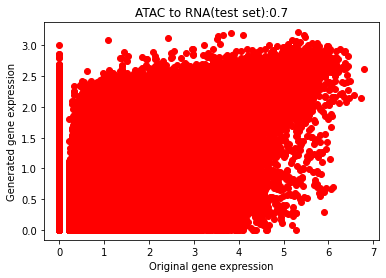

In [12]:
#enhancer_1
rna_raw = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_rna_fragments.h5ad")
trans_rna_test = np.load("drive/MyDrive/output_enhancer/rna_trans_output_test.npy")
target_name = pd.read_table("drive/MyDrive/output_enhancer/rna_targets_test.txt",header=None)

Pearson_col_shuffle(rna_raw, trans_rna_test, target_name)

Raw dataset for scRNA shape: (4482, 32285)
Processed dataset shape: (4482, 24528)
Pearson correlation: 0.7035556149123081


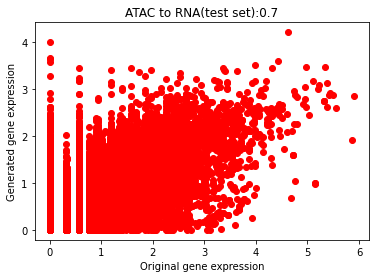

In [22]:
rna_raw = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_rna_fragments.h5ad")
trans_rna_test = np.load("drive/MyDrive/output_enhancer/rna_output_1.npy")

Pearson_col_enhancer(rna_raw, trans_rna_test)

In [10]:
trans_rna_test.shape

(897, 12461)

Raw dataset for scRNA shape: (4482, 32285)
Processed dataset shape: (4482, 24528)
pre rna shape: (4482, 24528)
new rna: (897, 24528)

Pearson correlation: 0.7356499029882835


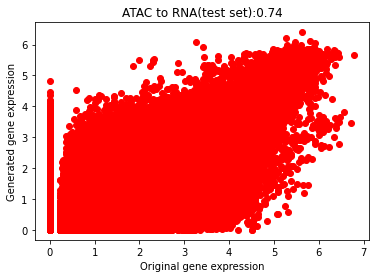

In [ ]:
#Baseline_mouse_brain
rna_raw = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_rna_fragments.h5ad")
#recon_rna_test = np.load("drive/MyDrive/output_0801_02/rna_recon_output_test.npy")
trans_rna_test = np.load("drive/MyDrive/output_0801_02/rna_trans_output_test.npy")
target_name = pd.read_table("drive/MyDrive/output_0801_02/rna_targets_test.txt",header=None)

Pearson_col_shuffle(rna_raw, trans_rna_test, target_name)
#Pearson_col(rna_raw, trans_rna_test)

Raw dataset for scRNA shape: (4474, 32285)
Processed dataset shape: (4474, 24526)
pre rna shape: (4474, 24526)
new rna: (895, 24526)
Pearson correlation: 0.7272235302100056


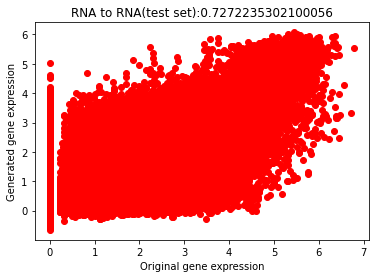

In [ ]:
rna_raw = sc.read_h5ad("drive/MyDrive/output_0731_04/e18_mouse_brain_fresh_5k_rna_fragments.h5ad")
trans_rna_test = np.load("drive/MyDrive/output_0731_07/rna_trans_output_test.npy")

Pearson_col(rna_raw, trans_rna_test)

Raw dataset for scRNA shape: (2864, 36601)
Processed dataset shape: (2864, 30637)
pre rna shape: (2864, 30637)
new rna: (573, 30637)
x (573, 30637)
y (573, 30637)
Pearson correlation: 0.7313497584106143


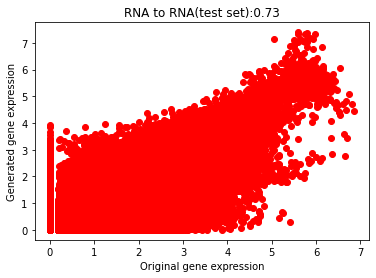

In [ ]:
#Baseline_human_brain
rna_raw = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/Frozen_human_healthy_brain/human_brain_3k_rna.h5ad")
recon_rna_test = np.load("drive/MyDrive/B2_Model/base_lr_output/frozen/rna_recon_output_test.npy")
target_name = pd.read_table("drive/MyDrive/B2_Model/base_lr_output/frozen/rna_targets_test.txt",header=None)


Pearson_col_shuffle(rna_raw, recon_rna_test, target_name)

Raw dataset for scRNA shape: (2864, 36601)
Processed dataset shape: (2864, 30637)
pre rna shape: (2864, 30637)
new rna: (573, 30637)
x (573, 30637)
y (573, 30637)
Pearson correlation: 0.7247336545660892


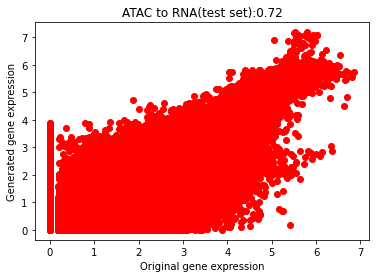

In [ ]:
#Baseline_human_brain
rna_raw = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/Frozen_human_healthy_brain/human_brain_3k_rna.h5ad")
trans_rna_test = np.load("drive/MyDrive/B2_Model/base_lr_output/frozen/rna_trans_output_test.npy")
target_name = pd.read_table("drive/MyDrive/B2_Model/base_lr_output/frozen/rna_targets_test.txt",header=None)


Pearson_col_shuffle(rna_raw, trans_rna_test, target_name)

In [ ]:
def AUROC(raw_atac, new_atac):
  pre_atac = preprocessing_atac(raw_atac)
  print("new atac test:", new_atac.shape)

  test_len = int(pre_atac.to_df().shape[0] * 0.8)
  
  pre_atac = pre_atac.to_df()
  pre_atac[pre_atac > 0] = 1

  x = pre_atac[test_len:].values.ravel()
  y = new_atac.ravel()
  print(metrics.roc_auc_score(x, y))

In [ ]:
def AUROC_shuffle(raw_atac, new_atac, target_name):
  pre_atac = preprocessing_atac(raw_atac)
  print("new atac test:", new_atac.shape)

  test_len = int(pre_atac.to_df().shape[0] * 0.8)
  
  pre_atac = pre_atac.to_df()
  pre_atac[pre_atac > 0] = 1

  df = pd.DataFrame(pre_atac.loc[target_name.iloc[0][0]]).T
  for i in range(1,target_name.shape[0]):
    cell = target_name.iloc[i][0]
    X = pre_atac.loc[cell]
    X_df = pd.DataFrame(X).T
    df = df.append(X_df)

  x = df.values.ravel()
  y = new_atac.ravel()
  print(metrics.roc_auc_score(x, y))

In [ ]:
#Baseline_recon_mouse_brain
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_atac_fragments.h5ad")
recon_atac_test = np.load("drive/MyDrive/output_0801_02/atac_recon_output_test.npy")
target_name = pd.read_table("drive/MyDrive/output_0801_02/atac_targets_test.txt",header=None)
#AUROC(raw_atac, trans_atac_test)
AUROC_shuffle(raw_atac, recon_atac_test, target_name)

Raw dataset for scATAC shape: (4482, 172193)


Processed dataset shape: (4482, 30002)
new atac test: (897, 30002)
0.6917966061884845


In [ ]:
#Baseline_trans_mouse_brain
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_atac_fragments.h5ad")
trans_atac_test = np.load("drive/MyDrive/output_0801_02/atac_trans_output_test.npy")
target_name = pd.read_table("drive/MyDrive/output_0801_02/atac_targets_test.txt",header=None)
#AUROC(raw_atac, trans_atac_test)
AUROC_shuffle(raw_atac, trans_atac_test, target_name)

Raw dataset for scATAC shape: (4482, 172193)


Processed dataset shape: (4482, 30002)
new atac test: (897, 30002)
0.6704435535347072


In [ ]:
#Baseline_recon_human_brain
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/Frozen_human_healthy_brain/human_brain_3k_atac.h5ad")
recon_atac_test = np.load("drive/MyDrive/B2_Model/base_lr_output/frozen/atac_recon_output_test.npy")
target_name = pd.read_table("drive/MyDrive/B2_Model/base_lr_output/frozen/atac_targets_test.txt",header=None)

AUROC_shuffle(raw_atac, recon_atac_test, target_name)

Raw dataset for scATAC shape: (2864, 134030)


Processed dataset shape: (2864, 30064)
new atac test: (573, 30064)
0.7081910845229282


In [ ]:
#Baseline_recon_human_brain
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/Frozen_human_healthy_brain/human_brain_3k_atac.h5ad")
trans_atac_test = np.load("drive/MyDrive/B2_Model/base_lr_output/frozen/atac_trans_output_test.npy")
target_name = pd.read_table("drive/MyDrive/B2_Model/base_lr_output/frozen/atac_targets_test.txt",header=None)

AUROC_shuffle(raw_atac, trans_atac_test, target_name)

Raw dataset for scATAC shape: (2864, 134030)


Processed dataset shape: (2864, 30064)
new atac test: (573, 30064)
0.7069063187599923


In [ ]:
#np.set_printoptions(threshold=np.inf)

In [ ]:
#latent space 
#rna_latent = np.load("./rna_output.npy")
#atac_latent = np.load("./atac_output.npy")

In [ ]:
#reconstruct data
#recon_rna_train = np.load("drive/MyDrive/rna_recon_output_train.npy")
#recon_rna_test = np.load("drive/MyDrive/rna_recon_output_test.npy")
#recon_atac_test = np.load("drive/MyDrive/atac_recon_output_test.npy")
#recon_atac_train = np.load("drive/MyDrive/atac_recon_output_train.npy")
#trans_atac_test = np.load("drive/MyDrive/0729-01/atac_trans_output_test.npy")
#

In [ ]:
#raw_data
#rna_raw = sc.read_h5ad('drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_rna_fragments.h5ad')
#atac_raw = sc.read_h5ad('drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_atac_fragments.h5ad')